In [7]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

Epoch 1/100, Loss: 0.043204738268233685
Epoch 2/100, Loss: 0.035418382360661936
Epoch 3/100, Loss: 0.03175859390543844
Epoch 4/100, Loss: 0.029033379566612193
Epoch 5/100, Loss: 0.027126119839629655
Epoch 6/100, Loss: 0.025824599453825287
Epoch 7/100, Loss: 0.024934277731053372
Epoch 8/100, Loss: 0.02432441568755089
Epoch 9/100, Loss: 0.023902059828654166
Epoch 10/100, Loss: 0.02359885671262309
Epoch 11/100, Loss: 0.023369410406995
Epoch 12/100, Loss: 0.02318673038327211
Epoch 13/100, Loss: 0.02303513246361491
Epoch 14/100, Loss: 0.02290508162304401
Epoch 15/100, Loss: 0.022790433029729204
Epoch 16/100, Loss: 0.022687120292803648
Epoch 17/100, Loss: 0.022592466352692842
Epoch 18/100, Loss: 0.022504720440570343
Epoch 19/100, Loss: 0.02242272009199911
Epoch 20/100, Loss: 0.022345620839662884
Epoch 21/100, Loss: 0.022272957449263716
Epoch 22/100, Loss: 0.022205063391811813
Epoch 23/100, Loss: 0.022142403405581587
Epoch 24/100, Loss: 0.022084760262938336
Epoch 25/100, Loss: 0.0220314223490

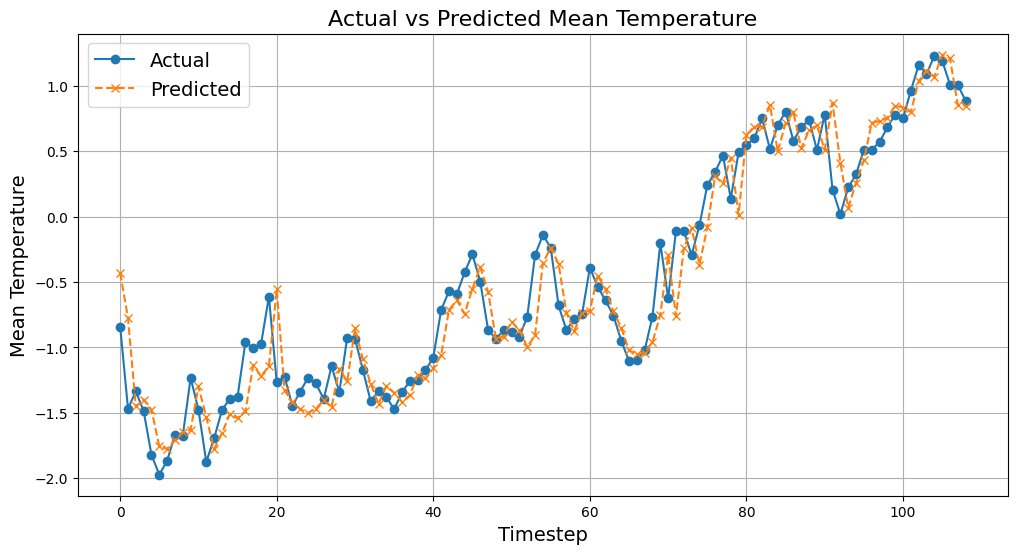

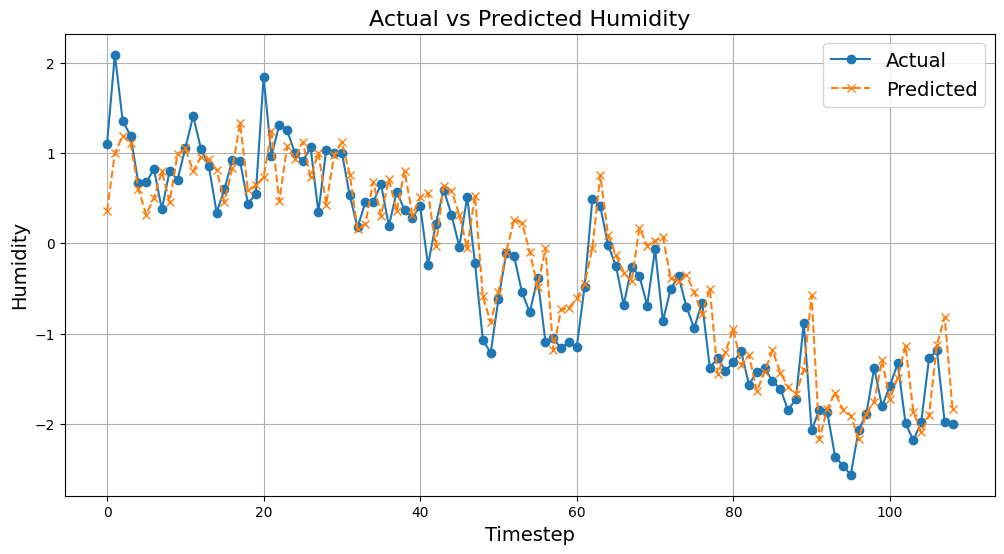

In [8]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt 
from models.gru import GRU
from losses.correlation_loss import CorrelationLoss
from losses.hybrid_loss import HybridLoss

# Read Data

train_path = "../datasets/DailyDelhiClimateTrain.csv"
test_path = "../datasets/DailyDelhiClimateTest.csv"

train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

# Preprocessing
def normalize(df, feature_means=None, feature_stds=None):
    if feature_means is None or feature_stds is None:
        feature_means = df.mean()
        feature_stds = df.std()
    return (df - feature_means) / feature_stds, feature_means, feature_stds

train_features = train[['meantemp', 'humidity', 'wind_speed', 'meanpressure']]
train_targets = train[['meantemp', 'humidity']]
train_features, train_means, train_stds = normalize(train_features)
train_targets, _, _ = normalize(train_targets, train_means[['meantemp', 'humidity']], train_stds[['meantemp', 'humidity']])

test_features = test[['meantemp', 'humidity', 'wind_speed', 'meanpressure']]
test_targets = test[['meantemp', 'humidity']]
test_features, _, _ = normalize(test_features, train_means, train_stds)
test_targets, _, _ = normalize(test_targets, train_means[['meantemp', 'humidity']], train_stds[['meantemp', 'humidity']])

train_features = torch.tensor(train_features.values, dtype=torch.float32)
train_targets = torch.tensor(train_targets.values, dtype=torch.float32)
test_features = torch.tensor(test_features.values, dtype=torch.float32)
test_targets = torch.tensor(test_targets.values, dtype=torch.float32)

# Create sequences for GRU
def create_sequences(features, targets, seq_length=5):
    X, y = [], []
    for i in range(len(features) - seq_length):
        X.append(features[i:i + seq_length])
        y.append(targets[i + seq_length])
    return torch.stack(X), torch.stack(y)

seq_length = 5
X_train, y_train = create_sequences(train_features, train_targets, seq_length)
X_test, y_test = create_sequences(test_features, test_targets, seq_length)

device = torch.device("cpu")
input_size = 4
hidden_size = 16
output_size = 2  # meantemp and humidity

gru_model = GRU(input_size, hidden_size, output_size, device).to(device)
criterion = HybridLoss(0.3) # NOTE ADJUST
optimizer = optim.Adam(gru_model.parameters(), lr=0.001)

# Training
num_epochs = 100
batch_size = 16

for epoch in range(num_epochs):
    gru_model.train()
    epoch_loss = 0
    for i in range(0, len(X_train), batch_size):
        X_batch = X_train[i:i + batch_size].to(device)
        y_batch = y_train[i:i + batch_size].to(device)

        optimizer.zero_grad()
        outputs = gru_model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(gru_model.parameters(), max_norm=1.0)
        optimizer.step()
        epoch_loss += loss.item()

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss / len(X_train)}")

# Testing
gru_model.eval()
with torch.no_grad():
    X_test = X_test.to(device)
    y_test = y_test.to(device)
    predictions = gru_model(X_test)
    test_loss = criterion(predictions, y_test)
    print(f"Test Loss: {test_loss.item()}")

# Plot results
def plot_results(y_true, y_pred, feature_name, feature_index):
    y_true = y_true.cpu().numpy()
    y_pred = y_pred.cpu().numpy()
    
    plt.figure(figsize=(12, 6))
    plt.plot(y_true[:, feature_index], label="Actual", linestyle='-', marker='o')
    plt.plot(y_pred[:, feature_index], label="Predicted", linestyle='--', marker='x')
    plt.title(f"Actual vs Predicted {feature_name}", fontsize=16)
    plt.xlabel("Timestep", fontsize=14)
    plt.ylabel(feature_name, fontsize=14)
    plt.legend(fontsize=14)
    plt.grid(True)
    plt.show()

plot_results(y_test, predictions, "Mean Temperature", 0)
plot_results(y_test, predictions, "Humidity", 1)


Epoch 1/100, Loss: 0.04564564931286306
Epoch 2/100, Loss: 0.036286684846174415
Epoch 3/100, Loss: 0.032773306333781435
Epoch 4/100, Loss: 0.030553735439795376
Epoch 5/100, Loss: 0.02892521731478757
Epoch 6/100, Loss: 0.027506704762445055
Epoch 7/100, Loss: 0.02628998208839597
Epoch 8/100, Loss: 0.0252928848371329
Epoch 9/100, Loss: 0.024494889967639558
Epoch 10/100, Loss: 0.023871541309618508
Epoch 11/100, Loss: 0.023388756614232113
Epoch 12/100, Loss: 0.023017054220422457
Epoch 13/100, Loss: 0.022735118109147353
Epoch 14/100, Loss: 0.02251797642459097
Epoch 15/100, Loss: 0.022345694961945488
Epoch 16/100, Loss: 0.022204754594138166
Epoch 17/100, Loss: 0.022085567886443194
Epoch 18/100, Loss: 0.021981585333628775
Epoch 19/100, Loss: 0.02188845501423864
Epoch 20/100, Loss: 0.021803319551352368
Epoch 21/100, Loss: 0.021724275191229506
Epoch 22/100, Loss: 0.021650027251030865
Epoch 23/100, Loss: 0.021579682423017905
Epoch 24/100, Loss: 0.021512623551616785
Epoch 25/100, Loss: 0.0214484225

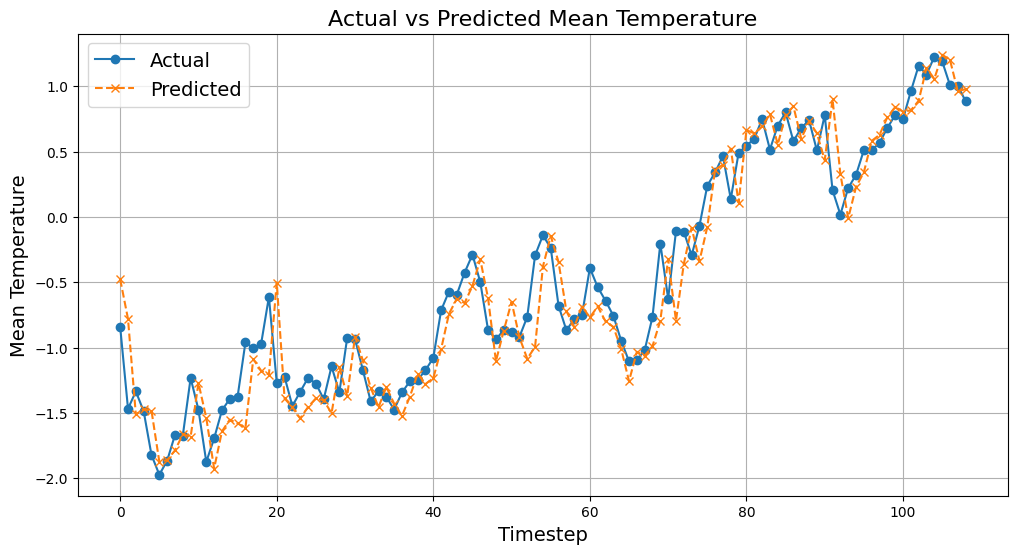

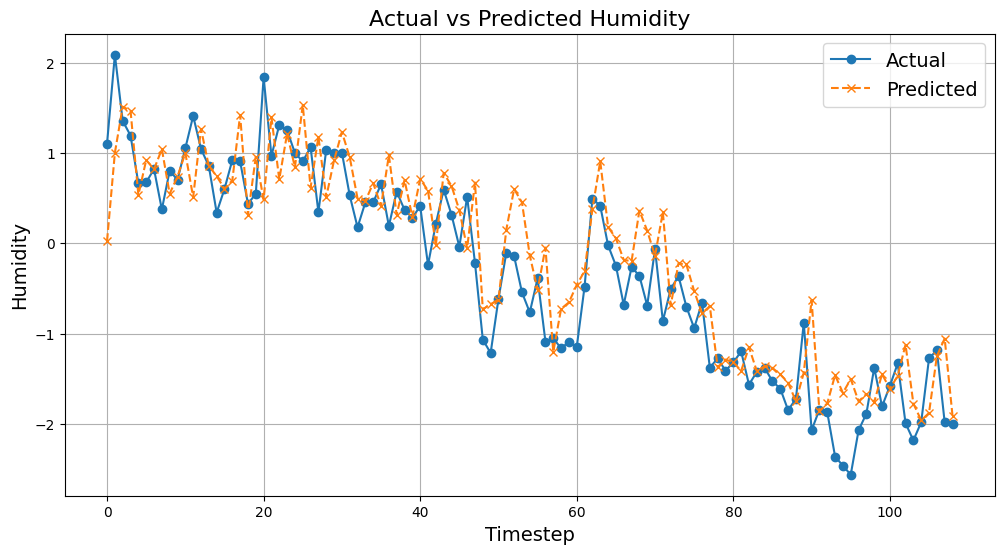

In [9]:
train_path = "../datasets/DailyDelhiClimateTrain.csv"
test_path = "../datasets/DailyDelhiClimateTest.csv"

train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

# Preprocessing
def normalize(df, feature_means=None, feature_stds=None):
    if feature_means is None or feature_stds is None:
        feature_means = df.mean()
        feature_stds = df.std()
    return (df - feature_means) / feature_stds, feature_means, feature_stds

train_features = train[['meantemp', 'humidity', 'wind_speed', 'meanpressure']]
train_targets = train[['meantemp', 'humidity']]
train_features, train_means, train_stds = normalize(train_features)
train_targets, _, _ = normalize(train_targets, train_means[['meantemp', 'humidity']], train_stds[['meantemp', 'humidity']])

test_features = test[['meantemp', 'humidity', 'wind_speed', 'meanpressure']]
test_targets = test[['meantemp', 'humidity']]
test_features, _, _ = normalize(test_features, train_means, train_stds)
test_targets, _, _ = normalize(test_targets, train_means[['meantemp', 'humidity']], train_stds[['meantemp', 'humidity']])

train_features = torch.tensor(train_features.values, dtype=torch.float32)
train_targets = torch.tensor(train_targets.values, dtype=torch.float32)
test_features = torch.tensor(test_features.values, dtype=torch.float32)
test_targets = torch.tensor(test_targets.values, dtype=torch.float32)

# Create sequences for AttentionGRU
def create_sequences(features, targets, seq_length=5):
    X, y = [], []
    for i in range(len(features) - seq_length):
        X.append(features[i:i + seq_length])
        y.append(targets[i + seq_length])
    return torch.stack(X), torch.stack(y)

seq_length = 5
X_train, y_train = create_sequences(train_features, train_targets, seq_length)
X_test, y_test = create_sequences(test_features, test_targets, seq_length)

device = torch.device("cpu")
input_size = 4
context_size = input_size  # assuming context comes from the same input features
hidden_size = 16
output_size = 2  # meantemp and humidity

# Initialize the AttentionGRU model & define loss and optimizer
attention_gru_model = AttentionGRU(input_size, hidden_size, context_size, output_size, device).to(device)
criterion = HybridLoss(0.3)  # Adjust weight if necessary
optimizer = optim.Adam(attention_gru_model.parameters(), lr=0.001)

# Training
num_epochs = 100
batch_size = 16

for epoch in range(num_epochs):
    attention_gru_model.train()
    epoch_loss = 0
    for i in range(0, len(X_train), batch_size):
        X_batch = X_train[i:i + batch_size].to(device)  # (batch_size, seq_length, input_size)
        y_batch = y_train[i:i + batch_size].to(device)  # (batch_size, output_size)
        
        context = X_batch  # (batch_size, seq_length, input_size)
        
        optimizer.zero_grad()
        outputs, _ = attention_gru_model(X_batch, context)  # outputs: (batch_size, seq_length, output_size)
        
        # NOTE We might need to adjust outputs and y_batch dimensions since outputs are per timestep, but y_batch is per sequence
        outputs = outputs[:, -1, :]  # (batch_size, output_size)
        
        loss = criterion(outputs, y_batch)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(attention_gru_model.parameters(), max_norm=1.0)
        optimizer.step()
        epoch_loss += loss.item()
    
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss / len(X_train)}")

# Testing
attention_gru_model.eval()
with torch.no_grad():
    X_test = X_test.to(device)
    y_test = y_test.to(device)
    context_test = X_test
    predictions, attention_weights = attention_gru_model(X_test, context_test)
    predictions = predictions[:, -1, :]
    test_loss = criterion(predictions, y_test)
    print(f"Test Loss: {test_loss.item()}")

# Plot results
def plot_results(y_true, y_pred, feature_name, feature_index):
    y_true = y_true.cpu().numpy()
    y_pred = y_pred.cpu().numpy()
    
    plt.figure(figsize=(12, 6))
    plt.plot(y_true[:, feature_index], label="Actual", linestyle='-', marker='o')
    plt.plot(y_pred[:, feature_index], label="Predicted", linestyle='--', marker='x')
    plt.title(f"Actual vs Predicted {feature_name}", fontsize=16)
    plt.xlabel("Timestep", fontsize=14)
    plt.ylabel(feature_name, fontsize=14)
    plt.legend(fontsize=14)
    plt.grid(True)
    plt.show()

plot_results(y_test, predictions, "Mean Temperature", 0)
plot_results(y_test, predictions, "Humidity", 1)

Epoch 1/100, Loss: 0.06347441068246736
Epoch 2/100, Loss: 0.0634902982855562
Epoch 3/100, Loss: 0.06355478320289497
Epoch 4/100, Loss: 0.06360860757492295
Epoch 5/100, Loss: 0.06371013806692918
Epoch 6/100, Loss: 0.06378579145699889
Epoch 7/100, Loss: 0.0636863600069554
Epoch 8/100, Loss: 0.06340912316911784
Epoch 9/100, Loss: 0.06369209331483697
Epoch 10/100, Loss: 0.06354218709408938
Epoch 11/100, Loss: 0.06369181571893356
Epoch 12/100, Loss: 0.06337508735944278
Epoch 13/100, Loss: 0.06372189821310378
Epoch 14/100, Loss: 0.06367365888614751
Epoch 15/100, Loss: 0.06367799067617062
Epoch 16/100, Loss: 0.06376013426325429
Epoch 17/100, Loss: 0.06368232929526861
Epoch 18/100, Loss: 0.06366510576938265
Epoch 19/100, Loss: 0.06350484133964807
Epoch 20/100, Loss: 0.06360177586426088
Epoch 21/100, Loss: 0.06355389386565242
Epoch 22/100, Loss: 0.06363012664881183
Epoch 23/100, Loss: 0.06349849347493157
Epoch 24/100, Loss: 0.06324489458122445
Epoch 25/100, Loss: 0.06353303673279345
Epoch 26/10

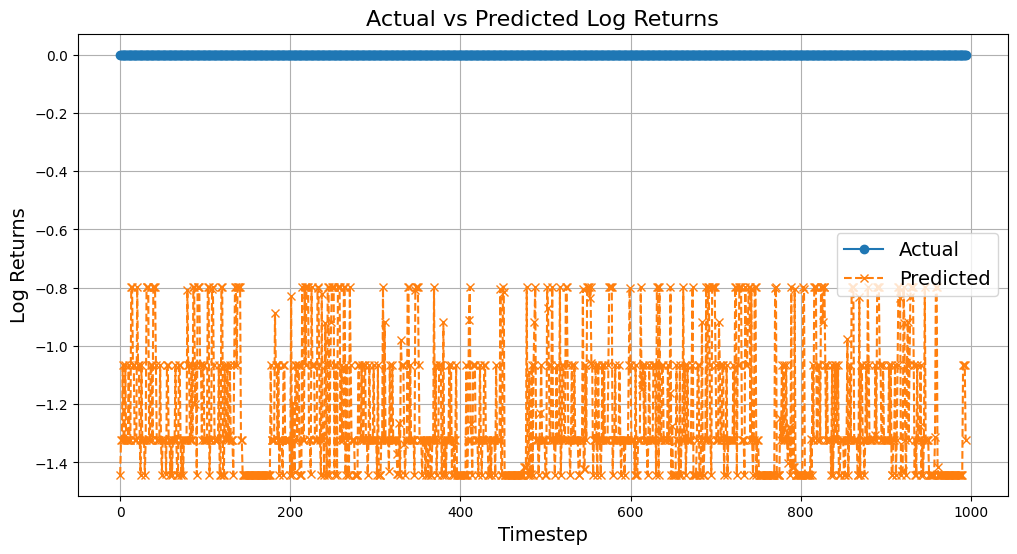

In [11]:
import numpy as np

train_path = "/pool/btcavax/binance-usdtfutures/trades/btc/2024-01-29.csv"
test_path = "/pool/btcavax/binance-usdtfutures/trades/btc/2024-01-30.csv"

train = pd.read_csv(train_path, sep="|")
test = pd.read_csv(test_path, sep="|")


# log returns column, look back 5 rows
def data_processing(df):
    curr = df.price
    back1 = df.price.shift(1)
    back2 = df.price.shift(2)
    back3 = df.price.shift(3)
    back4 = df.price.shift(4)
    back5 = df.price.shift(5)
    back6 = df.price.shift(6)
    df["log_returns"] = np.log(curr / back1)
    df["log_returns_back1"] = np.log(back1 / back2)
    df["log_returns_back2"] = np.log(back2 / back3)
    df["log_returns_back3"] = np.log(back3 / back4)
    df["log_returns_back4"] = np.log(back4 / back5)
    df["log_returns_back5"] = np.log(back5 / back6)

    return df.dropna().head(1000)


train = data_processing(train)
test = data_processing(test)

feature_columns = ["volume", "side", "log_returns_back1", "log_returns_back2", "log_returns_back3", "log_returns_back4", "log_returns_back5"]
target_columns = ["log_returns"]

train_features = train[feature_columns]
train_targets = train[target_columns]

test_features = test[feature_columns]
test_targets = test[target_columns]

train_features = torch.tensor(train_features.values, dtype=torch.float32)
train_targets = torch.tensor(train_targets.values, dtype=torch.float32)
test_features = torch.tensor(test_features.values, dtype=torch.float32)
test_targets = torch.tensor(test_targets.values, dtype=torch.float32)

# Create sequences for AttentionGRU
def create_sequences(features, targets, seq_length=5):
    X, y = [], []
    for i in range(len(features) - seq_length):
        X.append(features[i:i + seq_length])
        y.append(targets[i + seq_length])
    return torch.stack(X), torch.stack(y)

seq_length = 5
X_train, y_train = create_sequences(train_features, train_targets, seq_length)
X_test, y_test = create_sequences(test_features, test_targets, seq_length)

device = torch.device("cpu")
input_size = 7
context_size = input_size  # assuming context comes from the same input features
hidden_size = 16
output_size = 2  # meantemp and humidity

# Initialize the AttentionGRU model & define loss and optimizer
attention_gru_model = AttentionGRU(input_size, hidden_size, context_size, output_size, device).to(device)
criterion = CorrelationLoss()  # Adjust weight if necessary
optimizer = optim.Adam(attention_gru_model.parameters(), lr=0.001)

# Training
num_epochs = 100
batch_size = 16

for epoch in range(num_epochs):
    attention_gru_model.train()
    epoch_loss = 0
    for i in range(0, len(X_train), batch_size):
        X_batch = X_train[i:i + batch_size].to(device)  # (batch_size, seq_length, input_size)
        y_batch = y_train[i:i + batch_size].to(device)  # (batch_size, output_size)
        
        context = X_batch  # (batch_size, seq_length, input_size)
        
        optimizer.zero_grad()
        outputs, _ = attention_gru_model(X_batch, context)  # outputs: (batch_size, seq_length, output_size)
        
        # NOTE We might need to adjust outputs and y_batch dimensions since outputs are per timestep, but y_batch is per sequence
        outputs = outputs[:, -1, :]  # (batch_size, output_size)
        
        loss = criterion(outputs, y_batch)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(attention_gru_model.parameters(), max_norm=1.0)
        optimizer.step()
        epoch_loss += loss.item()
    
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss / len(X_train)}")

# Testing
attention_gru_model.eval()
with torch.no_grad():
    X_test = X_test.to(device)
    y_test = y_test.to(device)
    context_test = X_test
    predictions, attention_weights = attention_gru_model(X_test, context_test)
    predictions = predictions[:, -1, :]
    test_loss = criterion(predictions, y_test)
    print(f"Test Loss: {test_loss.item()}")

# Plot results
def plot_results(y_true, y_pred, feature_name, feature_index):
    y_true = y_true.cpu().numpy()
    y_pred = y_pred.cpu().numpy()
    
    plt.figure(figsize=(12, 6))
    plt.plot(y_true[:, feature_index], label="Actual", linestyle='-', marker='o')
    plt.plot(y_pred[:, feature_index], label="Predicted", linestyle='--', marker='x')
    plt.title(f"Actual vs Predicted {feature_name}", fontsize=16)
    plt.xlabel("Timestep", fontsize=14)
    plt.ylabel(feature_name, fontsize=14)
    plt.legend(fontsize=14)
    plt.grid(True)
    plt.show()

plot_results(y_test, predictions, "Log Returns", 0)
